# Оптимизация производственных расходов

Описание проекта: промышленность.

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

Описание данных

Данные состоят из файлов, полученных из разных источников:

data_arc_new.csv — данные об электродах;

data_bulk_new.csv — данные о подаче сыпучих материалов (объём);

data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);

data_gas_new.csv — данные о продувке сплава газом;

data_temp_new.csv — результаты измерения температуры;

data_wire_new.csv — данные о проволочных материалах (объём);

data_wire_time_new.csv — данные о проволочных материалах (время).

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error

from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score, KFold

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV

import shap

In [2]:
SEED=21023

In [3]:
try:
    src_folder_name = '../../data/fin-project/'
    data_arc       = pd.read_csv(src_folder_name + 'data_arc_new.csv')
    data_arc_new = pd.read_csv(src_folder_name + 'data_arc_new.csv')
    data_bulk_new = pd.read_csv(src_folder_name + 'data_bulk_new.csv')
    data_bulk_time_new = pd.read_csv(src_folder_name +'data_bulk_time_new.csv')
    data_gas_new = pd.read_csv(src_folder_name + 'data_gas_new.csv')
    data_temp_new = pd.read_csv(src_folder_name + 'data_temp_new.csv')
    data_wire_new = pd.read_csv(src_folder_name + 'data_wire_new.csv')
    data_wire_time_new = pd.read_csv(src_folder_name + 'data_wire_time_new.csv')
except FileNotFoundError:
    src_folder_name = '/datasets/'
    data_arc       = pd.read_csv(src_folder_name + 'data_arc_new.csv')
    data_arc_new = pd.read_csv(src_folder_name + 'data_arc_new.csv')
    data_bulk_new = pd.read_csv(src_folder_name + 'data_bulk_new.csv')
    data_bulk_time_new = pd.read_csv(src_folder_name +'data_bulk_time_new.csv')
    data_gas_new = pd.read_csv(src_folder_name + 'data_gas_new.csv')
    data_temp_new = pd.read_csv(src_folder_name + 'data_temp_new.csv')
    data_wire_new = pd.read_csv(src_folder_name + 'data_wire_new.csv')
    data_wire_time_new = pd.read_csv(src_folder_name + 'data_wire_time_new.csv')
data_list = [data_arc_new, data_bulk_new, data_bulk_time_new, data_gas_new, data_temp_new, data_wire_new, data_wire_time_new]

In [4]:
data_arc_new

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
...,...,...,...,...,...
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543


## Анализ данных

### Вспомогательные функции

In [5]:
def data_summary(data,name):
    print(f'***Заголовок таблицы {name}\n')
    display(data.head())
    print(f'\n***Общая информация по таблице {name}\n')
    data.info()
    print(f'\n\n***Стат. сводка по таблице {name}\n')
    display(data.describe())
    print('***Кол-во дубликатов: ',data.duplicated().sum())
    print('\n***Кол-во пропусков\n' , data.isna().sum())

In [6]:
def figure_numeric(data,name,fig_size = (2,2)):
    numeric_collums=list(data.select_dtypes(exclude='object').columns.drop('key'))
    plt.figure(figsize=fig_size)
    for i in range(len(numeric_collums)):
        plt.subplot(1,len(numeric_collums),i+1)
        data.boxplot(column=numeric_collums[i],grid=True)
    plt.suptitle(f'График «ящик с усами» для датасета {name}')
    plt.tight_layout()
    plt.show()

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ ТИМЛИДА</b></u></p>
    <p>с функциями - зачётно).</p>
</div>

### arc_new  Данные об электродах;

In [7]:
name = 'arc_new'
data = data_arc_new

In [8]:
data_summary(data,name)

***Заголовок таблицы arc_new



,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691



***Общая информация по таблице arc_new

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


***Стат. сводка по таблице arc_new



,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


***Кол-во дубликатов:  0

***Кол-во пропусков
 key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64


In [9]:
print('Кол-во партий', data_arc_new['key'].unique().shape[0])

Кол-во партий 3214


In [10]:
data_arc_new.isna().sum()

key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

In [11]:
data_arc_new.groupby(['key']).count().describe()

,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
count,3214.000000,3214.000000,3214.000000,3214.000000
mean,4.628500,4.628500,4.628500,4.628500
std,1.608647,1.608647,1.608647,1.608647
min,1.000000,1.000000,1.000000,1.000000
25%,4.000000,4.000000,4.000000,4.000000
50%,4.000000,4.000000,4.000000,4.000000
75%,6.000000,6.000000,6.000000,6.000000
max,16.000000,16.000000,16.000000,16.000000


In [12]:
print('Минимальное кол-во записей для каждой партии')
print(data_arc_new.groupby(['key']).count().min())
print('Максимальное кол-во записей для каждой партии')
print(data_arc_new.groupby(['key']).count().max())
print('Среднее кол-во записей для каждой партии')
data_arc_new.groupby(['key']).count().mean()

Минимальное кол-во записей для каждой партии
Начало нагрева дугой    1
Конец нагрева дугой     1
Активная мощность       1
Реактивная мощность     1
dtype: int64
Максимальное кол-во записей для каждой партии
Начало нагрева дугой    16
Конец нагрева дугой     16
Активная мощность       16
Реактивная мощность     16
dtype: int64
Среднее кол-во записей для каждой партии


Начало нагрева дугой    4.6285
Конец нагрева дугой     4.6285
Активная мощность       4.6285
Реактивная мощность     4.6285
dtype: float64

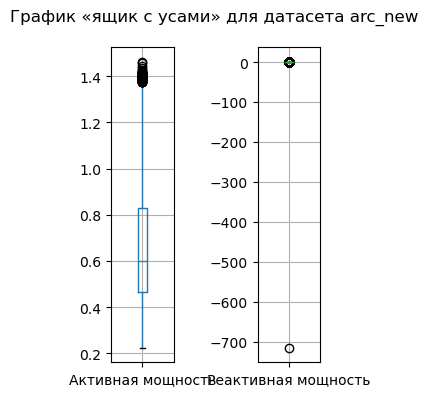

In [13]:
figure_numeric(data_arc_new,'arc_new',(3,4))

In [14]:
data_arc_new[data_arc_new['Реактивная мощность']<0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


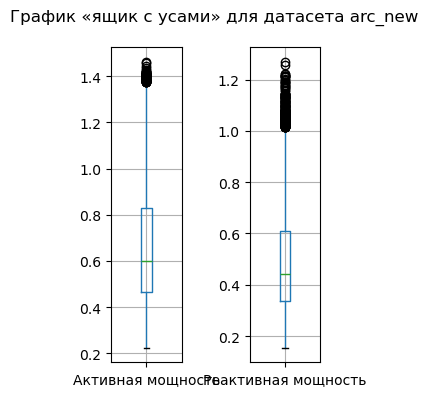

In [15]:
figure_numeric(data_arc_new[data_arc_new['Реактивная мощность']>=0],'arc_new',(3,4))

В данных по data_arc_new пропусков и дубликатов не обнаружено. Для каждей партии есть по крайней мере одна полная запись включающая все столбцы. Кол-во нагревов варьируется от 1 до 16. В столбце Реактивная мощность обнаружена аномалия - есть одна запись с отрицательным значением. 

Не понятно как предсказание температуры поможет в сокращении расходов на эл-во.
Расходы на эл-во предположительно  $\sim\sum (t2-t1) (a + r)$ сумма по всем запясям для заданной партии где t2, t1 всемя конца и начала нагрева. a и r мощности. 

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ ТИМЛИДА</b></u></p>
    <p>С выводами - ОК. По вопросу эффективности модели - обсудим на встрече сегодня)</p>
</div>

### bulk_new Данные о подаче сыпучих материалов (объём);

In [16]:
data_summary(data_bulk_new,'bulk_new')

***Заголовок таблицы bulk_new



,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0



***Общая информация по таблице bulk_new

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.3 KB


***Стат. сводка по таблице bulk_new



,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


***Кол-во дубликатов:  0

***Кол-во пропусков
 key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64


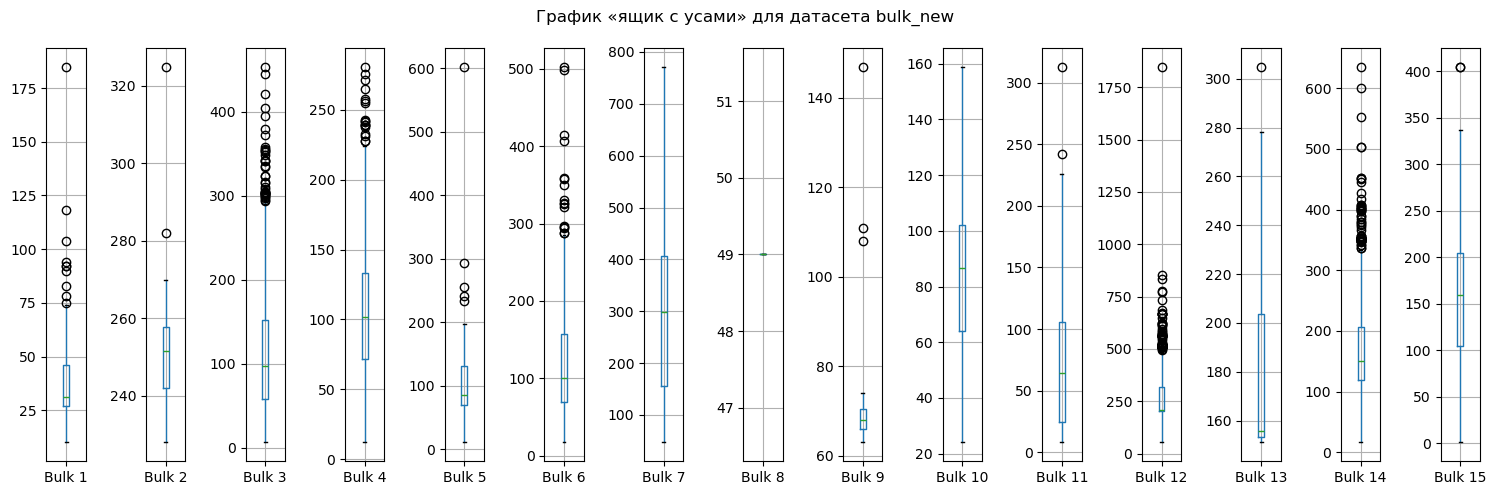

In [17]:
figure_numeric(data_bulk_new,'bulk_new',(15,5))

In [18]:
data_bulk_new['key'].unique().shape[0] == data_bulk_new['key'].count()

True

Данные data_bulk_new о подаче сыпучих материалов (объём) не однородны. Существенна доля пропусков которые видимо отражают что матерьял не добавлялся, т.е. можно заменить пропуски на нулевое численное значение. Для каждой партии только одна запись. 

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ ТИМЛИДА</b></u></p>
    <p>согласен.</p>
</div>

### bulk_time_new  - данные о подаче сыпучих материалов (время);

In [19]:
data_summary(data_bulk_time_new,'bulk_time_new')

***Заголовок таблицы bulk_time_new



,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47



***Общая информация по таблице bulk_time_new

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.3+ KB


***Стат. сводка по таблице bulk_time_new



,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


***Кол-во дубликатов:  0

***Кол-во пропусков
 key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64


In [20]:
data_summary(data_bulk_time_new,'bulk_time_new')

***Заголовок таблицы bulk_time_new



,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47



***Общая информация по таблице bulk_time_new

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.3+ KB


***Стат. сводка по таблице bulk_time_new



,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


***Кол-во дубликатов:  0

***Кол-во пропусков
 key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64


In [21]:
((data_bulk_time_new.isna()) == (data_bulk_new.isna())).count()

key        3129
Bulk 1     3129
Bulk 2     3129
Bulk 3     3129
Bulk 4     3129
Bulk 5     3129
Bulk 6     3129
Bulk 7     3129
Bulk 8     3129
Bulk 9     3129
Bulk 10    3129
Bulk 11    3129
Bulk 12    3129
Bulk 13    3129
Bulk 14    3129
Bulk 15    3129
dtype: int64

In [22]:
data_bulk_time_new['key'].unique().shape[0] == data_bulk_time_new['key'].count()

True

Данные data_bulk_time_new о времени подачи сыпучих материалов сопоставимы данным по объему. Существенна доля пропусков которые распалагаются там же где и в данных по объему. Для каждой партии только одна запись.

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ ТИМЛИДА</b></u></p>
    <p>Время (число, минута...) Как фактор в модель не будем брать. Сегодня обсудим.</p>
</div>

### gas_new.csv — данные о продувке сплава газом;

In [23]:
data_summary(data_gas_new,'gas_new')

***Заголовок таблицы gas_new



,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692



***Общая информация по таблице gas_new

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


***Стат. сводка по таблице gas_new



,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


***Кол-во дубликатов:  0

***Кол-во пропусков
 key      0
Газ 1    0
dtype: int64


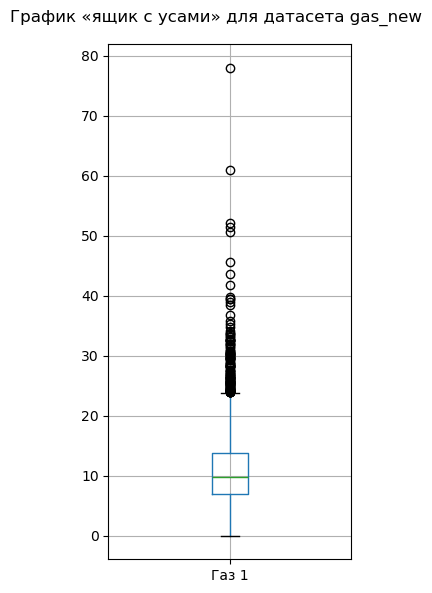

In [24]:
figure_numeric(data_gas_new,'gas_new',(3,6))

In [25]:
print('Кол-во дубликатов', data_gas_new.duplicated().sum())
print('Кол-во пропусков\n' , data_gas_new.isna().sum())

Кол-во дубликатов 0
Кол-во пропусков
 key      0
Газ 1    0
dtype: int64


В данных  data_gas_new не выявлено аномалий. Нет пропусков и дубликатов.

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ ТИМЛИДА</b></u></p>
    <p>ОК.</p>
</div>

### temp_new.csv — результаты измерения температуры;

In [26]:
data_summary(data_temp_new,'temp_new')

***Заголовок таблицы temp_new



,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0



***Общая информация по таблице temp_new

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


***Стат. сводка по таблице temp_new



,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


***Кол-во дубликатов:  0

***Кол-во пропусков
 key                0
Время замера       0
Температура     3427
dtype: int64


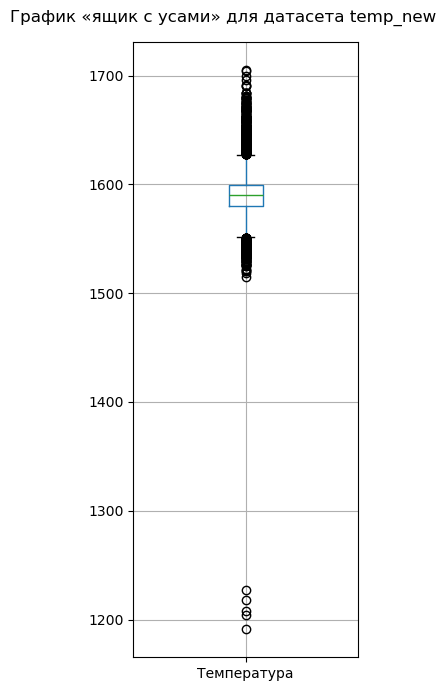

In [27]:
figure_numeric(data_temp_new,'temp_new',(3,7))

In [28]:
(data_temp_new.groupby('key').count()['Температура'] < 2 ).sum()

741

В данных  temp_new  по температуре пропусков и дубликатов не выявлено. Найдены аномально низкие температуры существенно ниже средней температуры плавления стали (1400 С). В 741 партии замер производился лишь один раз, что то не то с тех процесом. 

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ ТИМЛИДА</b></u></p>
хорошо. С выбросами тут действительно важный момент. Ведь выброс выбросу рознь) Бывает, что выброс - то реальная бизнес-практика. И если удалить их, то мы получим модель, так скажем, работующую не во всех диапазонах входящих в неё факторов. Т.е. по метрикам модель будет хорошая. А вот по бизнесу - не совсем применимая.<br>А бывают выбросы - точно выбросы - ошибки учёта данных, например.<br>

В таких проектах, также лучше использовать такую философию анализа выбросов:<br>
Ящик с усами - даёт пищу для размышлений (не более того, не воспринимаем его как сигнал к действию).<br>
А потом смотрим то явление, что изучаем. Данные значения - могут быть в реальности или нет?<br>
Вот, например, в случае с температурой плавления: по справочнику она у металла = около 1400+-, т.е. 1200 - действиетльно кажется очень странным значением. А 1450 и выше выглядит вполне рабочим, не смотря на статистические границы.<br><br>
    
По выбросам в этом проекте:: супервыбросы убираем со всей выборки (реактивная и температура менее 1400). А вот если другие выбросы будешь удалять (я бы не удалял), то давай условимся так: сделаем это только на трайн выборке. А тест будет чистая от удаления. Так мы будем близки к реальным условиям.<br>
Ведь если мы удаляем выбросы, а это не выбросы, то модель становится рабочей только на ограниченно диапазоне парамеров. Т.е. мы добъёмся хорошей метрики. Но модель при этом буде малопригодной)

### wire_new.csv — данные о проволочных материалах (объём);

In [29]:
data_summary(data_wire_new,'data_wire_new')

***Заголовок таблицы data_wire_new



,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN



***Общая информация по таблице data_wire_new

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


***Стат. сводка по таблице data_wire_new



,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


***Кол-во дубликатов:  0

***Кол-во пропусков
 key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64


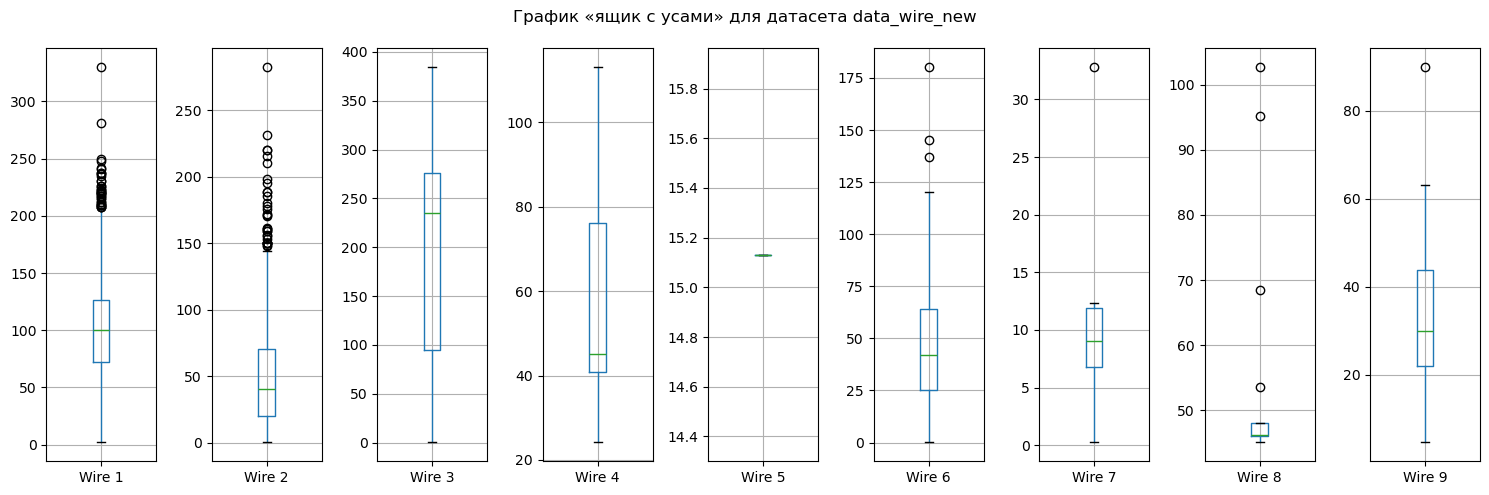

In [30]:
figure_numeric(data_wire_new,'data_wire_new',(15,5))

Данные о проволочных материалах (объём) не содержат явных дубликатов но содержат много пропусков, что видимо связано с тем что данный материал не добавлялся. Т.е. пропуски можно заменить на ноль. 

### wire_time_new.csv — данные о проволочных материалах (время).

In [31]:
data_summary(data_wire_time_new,'data_wire_time_new')

***Заголовок таблицы data_wire_time_new



,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN



***Общая информация по таблице data_wire_time_new

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


***Стат. сводка по таблице data_wire_time_new



,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


***Кол-во дубликатов:  0

***Кол-во пропусков
 key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64


### Выводы по первичному анализу данных. 

In [32]:
for i, d in enumerate(data_list):
    print(i,list(d.columns))

0 ['key', 'Начало нагрева дугой', 'Конец нагрева дугой', 'Активная мощность', 'Реактивная мощность']
1 ['key', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15']
2 ['key', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 13', 'Bulk 14', 'Bulk 15']
3 ['key', 'Газ 1']
4 ['key', 'Время замера', 'Температура']
5 ['key', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9']
6 ['key', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9']


In [33]:
print('Число уникальных номеров партий')
for d in data_list:
    print(d['key'].unique().shape[0], end = ', ')

Число уникальных номеров партий
3214, 3129, 3129, 3239, 3216, 3081, 3081, 

In [34]:
set(data_list[4]['key'].unique()).difference(set(data_list[0]['key'].unique()))

{195, 279}

In [35]:
print('Количество партий которые продувались газом но не нагревались')
len(set(data_list[3]['key'].unique()).difference(set(data_list[0]['key'].unique())))

Количество партий которые продувались газом но не нагревались


27

In [36]:
print('Количество партий которые нагревались но не продувались газом')
len(set(data_list[0]['key'].unique()).difference(set(data_list[3]['key'].unique())))

Количество партий которые нагревались но не продувались газом


2

В данных дубликатов не обнаружено. Есть разных данных разное кол-ко уникальных партии. 

Данные 
- data_bulk_new о подаче сыпучих материалов (объём),
- data_bulk_time_new о времени подачи сыпучих материалов
- data_wire_new о проволочных материалах (объём)
- data_wire_time_new о проволочных материалах (время)

содержат существенную долю пропусков которые видимо отражают что матерьял не добавлялся, т.е. можно заменить пропуски на нулевое численное значение.

В данных  temp_new  найдены аномально низкие температуры существеданные о проволочных материалах (объём);нно ниже средней температуры плавления стали (1400 С).

Есть данные по темпратуре партий {195, 279} которые не нагревались. Их нужно удалить.

Ряд записей указывает, что что то не то с тех процесом:
- в 741 партии замер производился лишь один раз.  
- 27 партий продувались газом но не нагревались.
- 2 партии продувались но не нагревались.

данные по этим партиям придется исключить 

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ ТИМЛИДА</b></u></p>
ОК, Александр, с первичным анализом - понятно. Есть и аналитика, и выводы, и графика, это верно.<br>

##  План & вопросы
- Предобработка данных (подготавливаем все признаки по которые потенциально можно исследовать в обучении)
    - удаление аномалий
    - замена пропусков
    - объединение по номеру партии в один датасет
- Анализ данных. 
    - изучение корреляций
    - выбор признаков
    - выбор целевой метрики
  На этом этапе мы должны сформировать весь список признаков для обучения. Исключить возможность утечки целевого признака. Так же необходимо сформировать данные по целевому признаку.
- Построение моделей (Decision tree, Linear regression, CatBoost)
  - разбивка данных на тестовую, обучающюю и валидационную.
  - маштабирование данных
  - обучение моделей
  - сравнение метрик на валидационной выборке. 
- Написать отчет  

1) Не понятно как предсказание температуры поможет в сокращении расходов на эл-во. 
Расходы на эл-во предположительно  $\sim\sum (t2-t1) (a + r)$ сумма по всем запясям для заданной партии где t2, t1 всемя конца и начала нагрева. a и r мощности.

2) Удалять ли данные нарушающие тех процесс
  - Есть данные по темпратуре партий {195, 279} которые не нагревались.
  - в 741 партии замер производился лишь один раз.
  - 27 партий продувались газом но не нагревались.
  - 2 партии продувались но не нагревались.

3) Удалять ли аномальные данные:
- отрицательное значение реактивной мощьности
- аномально низкие значения температуры. 

4) Разумно ли пропуски по подаче сыпучих и проволочных матерьялов заменить на ноль?

## Предобработка данных

### Чистка данных электродах

In [37]:
data_arc_new[data_arc_new['Реактивная мощность']<0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


In [38]:
arc = data_arc_new[data_arc_new['Реактивная мощность']>=0]

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ ТИМЛИДА 2</b></u></p>ок, тут можно удалять всю партию.

In [39]:
arc['time'] = ((pd.to_datetime(arc['Конец нагрева дугой'], format='%Y-%m-%d %H:%M:%S')
 -pd.to_datetime(arc['Начало нагрева дугой'], format='%Y-%m-%d %H:%M:%S')).dt.total_seconds().astype(int))

arc['power'] =  np.sqrt(arc['Активная мощность']**2 + arc['Реактивная мощность']**2)

arc['energy'] = arc['power'] * arc['time']

arc['energy_act'] = arc['Активная мощность'] * arc['time']

arc['ratio'] =  arc['Активная мощность']/arc['Реактивная мощность']

arc['ratio_inv'] =  arc['Реактивная мощность']/arc['Активная мощность']


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [40]:
arc_1 = pd.pivot_table(arc, index='key', 
               values=['Активная мощность','Реактивная мощность','time','power','energy','energy_act'], aggfunc=sum) 

arc_2 = arc.pivot_table(index='key',
                            values=['ratio','ratio_inv'],
                            aggfunc='sum')

arc_pivot = arc_1.join(arc_2)
arc_pivot.head()

,energy,energy_act,power,time,Активная мощность,Реактивная мощность,ratio,ratio_inv
key,,,,,,,,
1,770.282114,628.616930,3.718736,1098,3.036730,2.142821,7.107850,3.532845
2,481.760005,395.281800,2.588349,811,2.139408,1.453357,5.916805,2.736321
3,722.837668,581.774624,5.019223,655,4.063641,2.937457,6.980344,3.625168
4,683.455597,543.710274,3.400038,741,2.706489,2.056992,5.229785,3.063586
5,512.169934,412.180480,2.816980,869,2.252950,1.687991,5.315577,3.034397


<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ ТИМЛИДА 2</b></u></p>новые факторы в деле, согласен.

In [41]:
arc_pivot.corr()

,energy,energy_act,power,time,Активная мощность,Реактивная мощность,ratio,ratio_inv
energy,1.000000,0.999160,0.799076,0.896945,0.798433,0.796402,0.684337,0.689807
energy_act,0.999160,1.000000,0.797701,0.898045,0.798607,0.792249,0.688850,0.685914
power,0.799076,0.797701,1.000000,0.697578,0.999044,0.996904,0.874649,0.883342
time,0.896945,0.898045,0.697578,1.000000,0.698544,0.692445,0.772512,0.769444
Активная мощность,0.798433,0.798607,0.999044,0.698544,1.000000,0.992518,0.880592,0.878921
Реактивная мощность,0.796402,0.792249,0.996904,0.692445,0.992518,1.000000,0.859626,0.886991
ratio,0.684337,0.688850,0.874649,0.772512,0.880592,0.859626,1.000000,0.966940
ratio_inv,0.689807,0.685914,0.883342,0.769444,0.878921,0.886991,0.966940,1.000000


<div class="alert alert-warning" style="border-color: darkorange; border-radius: 5px">
    <p><u><b>⚠️ КОММЕНТАРИЙ ТИМЛИДА 2</b></u></p>
    <p>анализ есть, выводов нет((( Тогда к чему сам анализ? Тут лучше оставлять выводы после каждого аналитического вывода. В частности тут нам важна проблематика мультиколлинеарности. Добавь, пожалуйста.</p>
</div>

Да действительно тут не нужно было проводить этот анализ.  Он проведен ниже.

### Чистка данных по температуре

In [42]:
len_temp_new = len(data_temp_new)
len_temp_new

18092

In [43]:
temp = data_temp_new.query('Температура > 1250')

In [44]:
bad_keys = temp.groupby('key', as_index=False).count().query('Температура <2')['key']
len(bad_keys)

740

In [45]:
temp = temp[~temp['key'].isin(bad_keys)]

In [46]:
dat = pd.to_datetime(temp['Время замера'], format='%Y-%m-%d %H:%M:%S')
((dat.sort_values()) == dat).mean()

1.0

In [47]:
len(dat)-len(dat.unique())

0

In [48]:
temp_pivot = temp.pivot_table(index='key',
                              values='Температура',
                              aggfunc=['first','last'])
temp_pivot.columns = ['temp_first','temp_last']
temp_pivot.head()

,temp_first,temp_last
key,,
1,1571.0,1613.0
2,1581.0,1602.0
3,1596.0,1599.0
4,1601.0,1625.0
5,1576.0,1602.0


In [49]:
temp_pivot

,temp_first,temp_last
key,,
1,1571.0,1613.0
2,1581.0,1602.0
3,1596.0,1599.0
4,1601.0,1625.0
5,1576.0,1602.0
...,...,...
2495,1570.0,1591.0
2496,1554.0,1591.0
2497,1571.0,1589.0


<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ ТИМЛИДА 2</b></u></p>Отлично, это важный момент в проекте - оставить только те партии, которые нужны.

In [50]:
(temp_pivot['temp_first'] < temp_pivot['temp_last']).mean()

0.6133333333333333

<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ ТИМЛИДА 2</b></u></p>а это к чему, нам это важно?

### Чистка данных по  сыпучим

In [51]:
# Группировка по номеру партии
bulk_pivot = data_bulk_new.fillna(0).pivot_table(index='key',
                            aggfunc='sum')
bulk_pivot.head()

,Bulk 1,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9
key,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,206.0,0.0,150.0,154.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,206.0,0.0,149.0,154.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,205.0,0.0,152.0,153.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,207.0,0.0,153.0,154.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,203.0,0.0,151.0,152.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0


<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ ТИМЛИДА</b></u></p>ок, с нулём полностью согласен.

### Чистка данных по проволочным

In [52]:
# Группировка по номеру партии
wire_pivot = data_wire_new.fillna(0).pivot_table(index='key',
                            aggfunc='sum')
wire_pivot.head()

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,,,,,,,,,
1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Обработка данных по газу

In [53]:
gas_pivot = data_gas_new.fillna(0).pivot_table(index='key', aggfunc='sum')

In [54]:
gas_pivot

,Газ 1
key,
1,29.749986
2,12.555561
3,28.554793
4,18.841219
5,5.413692
...,...
3237,5.543905
3238,6.745669
3239,16.023518


In [55]:
data_gas_new

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


### Объединение данных 

In [56]:
# Объединение таблиц
data_final = arc_pivot.join([temp_pivot, gas_pivot, bulk_pivot, wire_pivot],how = "inner")
data_final.head()

,energy,energy_act,power,time,Активная мощность,Реактивная мощность,ratio,ratio_inv,temp_first,temp_last,...,Bulk 9,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,,,,,,,,,,,,,,,,,,,,,
1,770.282114,628.616930,3.718736,1098,3.036730,2.142821,7.107850,3.532845,1571.0,1613.0,...,0.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,481.760005,395.281800,2.588349,811,2.139408,1.453357,5.916805,2.736321,1581.0,1602.0,...,0.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,722.837668,581.774624,5.019223,655,4.063641,2.937457,6.980344,3.625168,1596.0,1599.0,...,0.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,683.455597,543.710274,3.400038,741,2.706489,2.056992,5.229785,3.063586,1601.0,1625.0,...,0.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,512.169934,412.180480,2.816980,869,2.252950,1.687991,5.315577,3.034397,1576.0,1602.0,...,0.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
data_final

,energy,energy_act,power,time,Активная мощность,Реактивная мощность,ratio,ratio_inv,temp_first,temp_last,...,Bulk 9,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,,,,,,,,,,,,,,,,,,,,,
1,770.282114,628.616930,3.718736,1098,3.036730,2.142821,7.107850,3.532845,1571.0,1613.0,...,0.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,481.760005,395.281800,2.588349,811,2.139408,1.453357,5.916805,2.736321,1581.0,1602.0,...,0.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,722.837668,581.774624,5.019223,655,4.063641,2.937457,6.980344,3.625168,1596.0,1599.0,...,0.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,683.455597,543.710274,3.400038,741,2.706489,2.056992,5.229785,3.063586,1601.0,1625.0,...,0.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,512.169934,412.180480,2.816980,869,2.252950,1.687991,5.315577,3.034397,1576.0,1602.0,...,0.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,694.177326,571.539318,3.868721,723,3.168133,2.210936,5.661119,2.868113,1570.0,1591.0,...,0.0,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2496,815.818538,675.222467,5.070316,940,4.174918,2.872031,8.625659,4.194016,1554.0,1591.0,...,0.0,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2497,823.020520,680.326674,4.360918,569,3.605239,2.452092,4.431517,2.034544,1571.0,1589.0,...,0.0,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ ТИМЛИДА 2</b></u></p>
мержевавние - верно)

In [58]:
data_final=data_final[~data_final['temp_last'].isna()]

In [59]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 1 to 2499
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   energy               2329 non-null   float64
 1   energy_act           2329 non-null   float64
 2   power                2329 non-null   float64
 3   time                 2329 non-null   int64  
 4   Активная мощность    2329 non-null   float64
 5   Реактивная мощность  2329 non-null   float64
 6   ratio                2329 non-null   float64
 7   ratio_inv            2329 non-null   float64
 8   temp_first           2329 non-null   float64
 9   temp_last            2329 non-null   float64
 10  Газ 1                2329 non-null   float64
 11  Bulk 1               2329 non-null   float64
 12  Bulk 10              2329 non-null   float64
 13  Bulk 11              2329 non-null   float64
 14  Bulk 12              2329 non-null   float64
 15  Bulk 13              2329 non-null   f

In [60]:
data_final.describe()

,energy,energy_act,power,time,Активная мощность,Реактивная мощность,ratio,ratio_inv,temp_first,temp_last,...,Bulk 9,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,...,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.0,2329.000000,2329.000000,2329.000000,2329.000000
mean,669.741514,538.967370,3.884654,807.600687,3.125033,2.300522,6.438779,3.456057,1587.386003,1593.365393,...,0.444826,102.443601,17.609859,3.234916,0.306550,0.0,0.978820,0.006361,0.311311,0.317113
std,319.531949,257.314897,1.518157,340.897332,1.221007,0.903968,2.227934,1.190008,23.619841,11.200915,...,6.220641,43.539993,33.624771,27.942871,4.757746,0.0,8.693299,0.205705,4.402707,3.456561
min,33.430208,26.187544,0.331897,57.000000,0.267676,0.196228,1.112383,0.601191,1519.000000,1541.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,457.864703,368.130458,2.843058,581.000000,2.293900,1.669572,5.195876,2.778051,1571.000000,1587.000000,...,0.000000,73.207679,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,630.714148,508.068106,3.767499,778.000000,3.035365,2.225398,6.395123,3.426884,1587.000000,1593.000000,...,0.000000,101.119201,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
75%,841.398018,678.323372,4.769421,993.000000,3.834300,2.829159,7.861281,4.252056,1603.000000,1598.000000,...,0.000000,128.091599,23.102560,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
max,4546.405812,3718.054401,15.288271,4189.000000,12.375636,8.949049,22.770854,11.329168,1660.000000,1653.000000,...,147.000000,330.314424,282.780152,385.008668,113.231044,0.0,180.454575,8.490040,102.762401,62.025600


### Выводы по предобработке данных

Проведена минимальная чистка данных:
- убрана запись с отрицательной мощностью
- добавлены доп. признаки: общая мощность, затраченая энергия, отношение активной и реактивной мощностей
- убраны записи с низкими температурами (ниже 1300)
- убраны записи с партиями для которых был только один замер температуры.
- пропуски в объемах примесей (wire и bulk)
- добавлена в таблицу arc длительность каждого нагрева. другие даные по времени убраны из таблиц (arc и temp)

Проведена группировка и агрегация данных по партиям для каждой таблицы

Все таблицы объеденины в одну оставлены только партии которые встречаются во всех исходных таблицах. 

## Обучение моделей

In [61]:
k_f = KFold(n_splits=5, shuffle=True, random_state=SEED)

### Анализ корреляций и выбор признаков

In [62]:
data_train, data_test = train_test_split(data_final, random_state=SEED, shuffle=True, test_size=0.25)

In [63]:
data_train['random']=np.random.randn(data_train.shape[0])
data_train.corr()['random']

energy                 0.011265
energy_act             0.011236
power                 -0.006101
time                  -0.003659
Активная мощность     -0.006626
Реактивная мощность   -0.005098
ratio                 -0.022024
ratio_inv             -0.022043
temp_first             0.019368
temp_last              0.017593
Газ 1                 -0.014899
Bulk 1                 0.004215
Bulk 10                0.005451
Bulk 11                0.005312
Bulk 12                0.016005
Bulk 13                0.011957
Bulk 14                0.057660
Bulk 15               -0.002899
Bulk 2                -0.018194
Bulk 3                -0.029575
Bulk 4                -0.000211
Bulk 5                -0.043569
Bulk 6                -0.028185
Bulk 7                -0.029057
Bulk 8                -0.022326
Bulk 9                -0.028698
Wire 1                -0.008618
Wire 2                -0.038066
Wire 3                -0.030878
Wire 4                -0.013142
Wire 5                      NaN
Wire 6  

In [64]:
data_final.corr()['temp_last'].head(7)

energy                 0.256611
energy_act             0.258558
power                  0.175668
time                   0.278716
Активная мощность      0.177339
Реактивная мощность    0.171878
ratio                  0.182444
Name: temp_last, dtype: float64

In [65]:
data_train.corr()['temp_last']

energy                 0.242474
energy_act             0.244041
power                  0.162876
time                   0.276455
Активная мощность      0.164129
Реактивная мощность    0.159843
ratio                  0.181478
ratio_inv              0.176283
temp_first             0.290507
temp_last              1.000000
Газ 1                  0.042616
Bulk 1                -0.095395
Bulk 10                0.065701
Bulk 11               -0.128753
Bulk 12                0.270136
Bulk 13                0.001243
Bulk 14                0.124693
Bulk 15                0.263041
Bulk 2                -0.099895
Bulk 3                -0.043500
Bulk 4                 0.190462
Bulk 5                -0.033289
Bulk 6                -0.180205
Bulk 7                -0.197684
Bulk 8                -0.030760
Bulk 9                -0.019788
Wire 1                 0.326849
Wire 2                -0.226393
Wire 3                -0.053939
Wire 4                -0.185686
Wire 5                      NaN
Wire 6  

In [66]:
data_train['Wire 5'].sum()

0.0

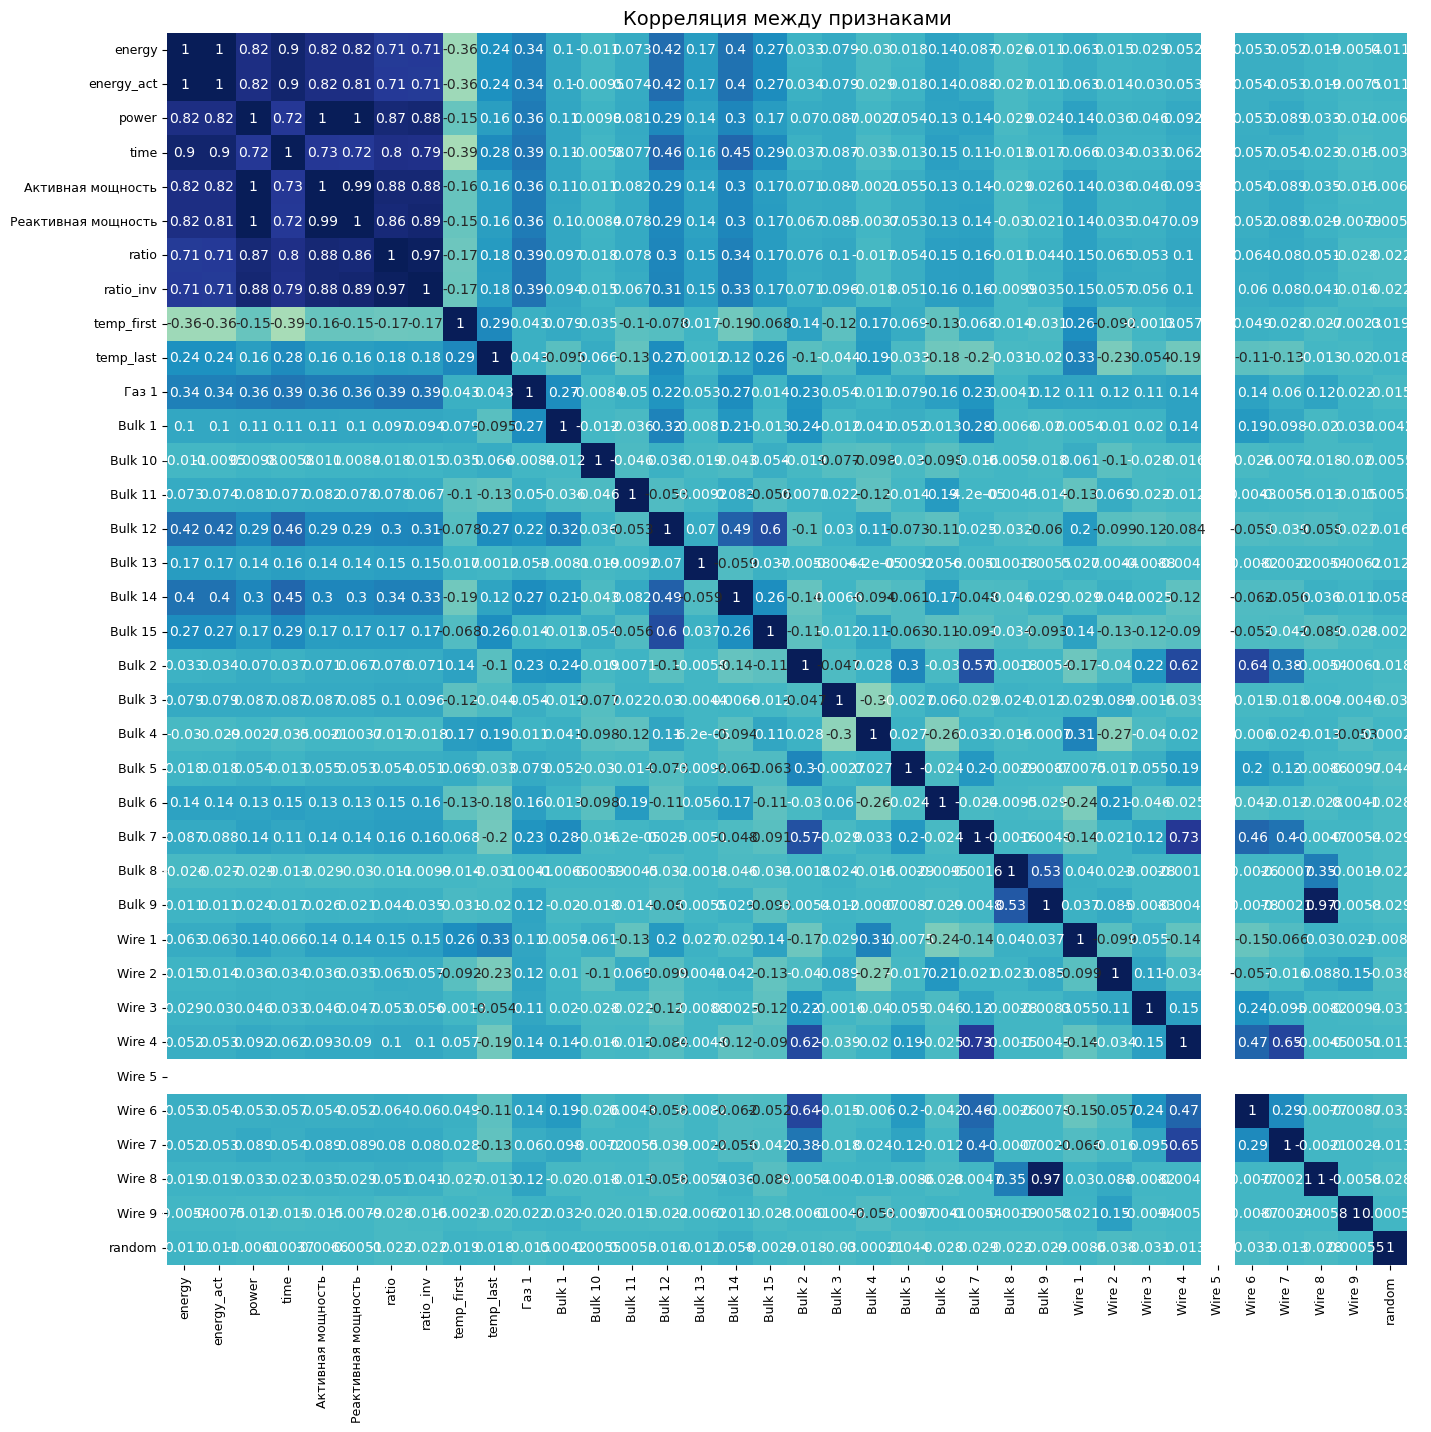

In [67]:
plt.figure(figsize=(16,16), dpi= 100)
sns.heatmap(
    data_train.corr(), xticklabels=data_train.corr().columns,
    yticklabels=data_train.corr().columns, annot=True, center=0, cbar=False, cmap='YlGnBu')

plt.title('Корреляция между признаками', fontsize=14)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.show()

ряд признаков сильно коррелируют что указывает на возможную мультиколлинеарность. с собой поэтому мы исключим некоторые из них`['energy_act', 'power', 'ratio', 'ratio_inv','Реактивная мощность','Активная мощность']`  а так же те признаки которые слабо скоррелированы с конечной температурой. 

In [68]:
corr_table = data_train.drop('random',axis=1).corr()
delete_column = list(corr_table[(corr_table['temp_last'] > -0.03) & 
                                 (corr_table['temp_last'] < 0.03)].index)
delete_column

['Bulk 13', 'Bulk 9', 'Wire 8', 'Wire 9']

In [69]:
delete_column = delete_column + ['energy_act', 'power', 'ratio', 'ratio_inv','Реактивная мощность','Wire 5','Активная мощность']

In [70]:
data_fin = data_final.drop(delete_column, axis=1)

In [71]:
data_fin.columns

Index(['energy', 'time', 'temp_first', 'temp_last', 'Газ 1', 'Bulk 1',
       'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 14', 'Bulk 15', 'Bulk 2',
       'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Wire 1',
       'Wire 2', 'Wire 3', 'Wire 4', 'Wire 6', 'Wire 7'],
      dtype='object')

In [72]:
data_fin

,energy,time,temp_first,temp_last,Газ 1,Bulk 1,Bulk 10,Bulk 11,Bulk 12,Bulk 14,...,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7
key,,,,,,,,,,,,,,,,,,,,,
1,770.282114,1098,1571.0,1613.0,29.749986,0.0,0.0,0.0,206.0,150.0,...,0.0,0.0,0.0,0.0,60.059998,0.00000,0.0,0.0,0.0,0.0
2,481.760005,811,1581.0,1602.0,12.555561,0.0,0.0,0.0,206.0,149.0,...,0.0,0.0,0.0,0.0,96.052315,0.00000,0.0,0.0,0.0,0.0
3,722.837668,655,1596.0,1599.0,28.554793,0.0,0.0,0.0,205.0,152.0,...,0.0,0.0,0.0,0.0,91.160157,0.00000,0.0,0.0,0.0,0.0
4,683.455597,741,1601.0,1625.0,18.841219,0.0,0.0,0.0,207.0,153.0,...,0.0,0.0,0.0,0.0,89.063515,0.00000,0.0,0.0,0.0,0.0
5,512.169934,869,1576.0,1602.0,5.413692,0.0,0.0,0.0,203.0,151.0,...,0.0,0.0,0.0,0.0,89.238236,9.11456,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,694.177326,723,1570.0,1591.0,7.125735,0.0,90.0,0.0,256.0,129.0,...,0.0,0.0,0.0,0.0,89.150879,0.00000,0.0,0.0,0.0,0.0
2496,815.818538,940,1554.0,1591.0,9.412616,0.0,122.0,0.0,256.0,129.0,...,0.0,0.0,0.0,0.0,114.179527,0.00000,0.0,0.0,0.0,0.0
2497,823.020520,569,1571.0,1589.0,6.271699,0.0,0.0,0.0,230.0,124.0,...,0.0,0.0,0.0,0.0,94.086723,9.04800,0.0,0.0,0.0,0.0


### Выборки и предподготовка данных

In [73]:
target = data_fin['temp_last']
features = data_fin.drop('temp_last',axis=1)

features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                            random_state=SEED, 
                                                                            shuffle=True, test_size=0.25)

In [74]:
# Проверка на соответсвие размеров выборок
print('Размер тестовой выборки:')
print('features_test:',features_test.shape)
print('target_test:',target_test.shape)

print()
print('Размер обучающей выборки:')
print('features_train:',features_train.shape)
print('target_train:',target_train.shape)

Размер тестовой выборки:
features_test: (583, 23)
target_test: (583,)

Размер обучающей выборки:
features_train: (1746, 23)
target_train: (1746,)


In [75]:
# маштабирование данных
scaler = StandardScaler()
#scaler.fit(features_train) 
features_train = pd.DataFrame(scaler.fit_transform(features_train),columns=features.columns)
features_test = pd.DataFrame(scaler.transform(features_test),columns=features.columns)

features_test

,energy,time,temp_first,Газ 1,Bulk 1,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,...,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7
0,0.738758,-0.044592,-0.111746,-0.849867,-0.275832,-0.24626,7.011684,-1.325289,-1.900848,-1.430035,...,-0.120108,2.914793,-0.066421,-0.023939,1.228826,3.109443,-0.115597,-0.063055,-0.107469,-0.029399
1,0.039947,0.500050,0.482969,-0.246646,-0.275832,-0.24626,-0.188560,-0.016640,-0.599733,-0.202278,...,-0.120108,-0.396270,-0.066421,-0.023939,-0.636405,-0.533333,-0.115597,-0.063055,-0.107469,-0.029399
2,0.165160,0.867028,0.865285,-0.410721,-0.275832,-0.24626,-0.188560,0.663344,0.463678,1.037399,...,-0.120108,-0.396270,-0.066421,-0.023939,-1.050329,-0.533333,-0.115597,-0.063055,-0.107469,-0.029399
3,-1.388212,-1.063976,-0.494063,-1.480249,-0.275832,-0.24626,-0.188560,-1.325289,-1.900848,-1.430035,...,-0.120108,1.250313,-0.066421,-0.023939,-0.294947,-0.533333,-0.115597,-0.063055,-0.107469,-0.029399
4,0.391139,0.473837,-0.536543,0.015622,-0.275832,-0.24626,-0.188560,-0.003810,-0.437094,-0.190358,...,-0.120108,-0.396270,-0.066421,-0.023939,1.272777,0.547144,-0.115597,-0.063055,-0.107469,-0.029399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578,1.207809,1.231094,-1.428615,0.445802,-0.275832,-0.24626,-0.188560,1.952748,1.176788,-1.430035,...,-0.120108,-0.396270,-0.066421,-0.023939,-1.712665,1.940708,-0.115597,-0.063055,-0.107469,-0.029399
579,2.162100,2.119414,0.228091,1.575453,-0.275832,-0.24626,-0.188560,1.625586,1.064192,1.228119,...,-0.120108,-0.396270,-0.066421,-0.023939,0.673545,-0.533333,-0.115597,-0.063055,-0.107469,-0.029399
580,-0.568749,-0.350407,-0.324144,-0.679313,-0.275832,-0.24626,-0.188560,0.349012,-0.424583,1.430758,...,-0.120108,-0.396270,-0.066421,-0.023939,0.422418,1.658279,-0.115597,-0.063055,-0.107469,-0.029399
581,-0.149459,-0.711560,-0.536543,-0.243064,-0.275832,-0.24626,-0.188560,-1.325289,1.827346,-1.430035,...,-0.120108,1.089234,-0.066421,-0.023939,-0.405931,-0.533333,-0.115597,-0.063055,-0.107469,-0.029399


### Dummy модель 

In [76]:
model_dummy = DummyRegressor(strategy='mean')

model_dummy.fit(features_train, target_train)
prediction_dummy = model_dummy.predict(features_train)

mae_dummy = mean_absolute_error(prediction_dummy,target_train)

In [77]:
mae_dummy

8.087870950980742

### Линейная модель 

In [78]:
model_linear = LinearRegression()
scores = cross_val_score(model_linear, features_train, target_train, cv=k_f, scoring='neg_mean_absolute_error') 
-np.mean(scores)

6.452447108640466

In [79]:
clf = Ridge(alpha=100)
scores = cross_val_score(clf, features_train, target_train, cv=k_f, scoring='neg_mean_absolute_error') 
mae_clf = -np.mean(scores)

In [80]:
mae_clf

6.378971420684335

### RandomForestRegressor

In [81]:
fitting = False

In [82]:
%%time

if fitting:
    parameters_grid = {
        'n_estimators': list(range(20,40,2)), 
        'max_depth': [4,6, 8, 10], 
        'min_samples_split': [1, 2, 3, 4]
        }
    print('Количество моделей', np.prod([len(i) for i in parameters_grid.values()]))
    model_forest = RandomForestRegressor(random_state=SEED)
    cv_forest = GridSearchCV(
        estimator=model_forest, 
        param_grid=parameters_grid , 
        cv= k_f, 
        scoring='neg_mean_absolute_error',
        verbose=1)
    cv_forest.fit(features_train, target_train)
    
    parameters_forest=cv_forest.best_params_
    print('parameters_forest=',parameters_forest)
    print('best score for forest=',-cv_forest.best_score_)
    
else:
    parameters_forest= {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 38}
    model_forest = RandomForestRegressor(random_state=SEED,**parameters_forest)

CPU times: user 266 µs, sys: 104 µs, total: 370 µs
Wall time: 67.2 µs


In [83]:
%%time 
scores_forest = - cross_val_score(model_forest,
                                 features_train, target_train,
                                 cv=k_f,
                                 scoring="neg_mean_absolute_error")

print('средний MAE=',np.mean(scores_forest))

средний MAE= 6.262055099295884
CPU times: user 1.59 s, sys: 361 ms, total: 1.96 s
Wall time: 1.54 s


### Catboost

In [84]:
model_catboost = CatBoostRegressor(loss_function = 'MAE',
                                   iterations=300, 
                                   verbose=False, 
                                   random_state=SEED)

model_catboost.fit(features_train, target_train)
scores = - cross_val_score(model_catboost, features_train, target_train, cv=k_f, scoring='neg_mean_absolute_error')
mae_catboost = np.mean(scores)

In [85]:
mae_catboost

6.064354044121567

### Оценка качечества выбранной модели 

In [86]:
predictions_catboost = model_catboost.predict(features_test)
mae_catboost = mean_absolute_error(predictions_catboost, target_test) 
mae_catboost

6.092884785223986

Text(0.5, 1.0, 'Feature Importance')

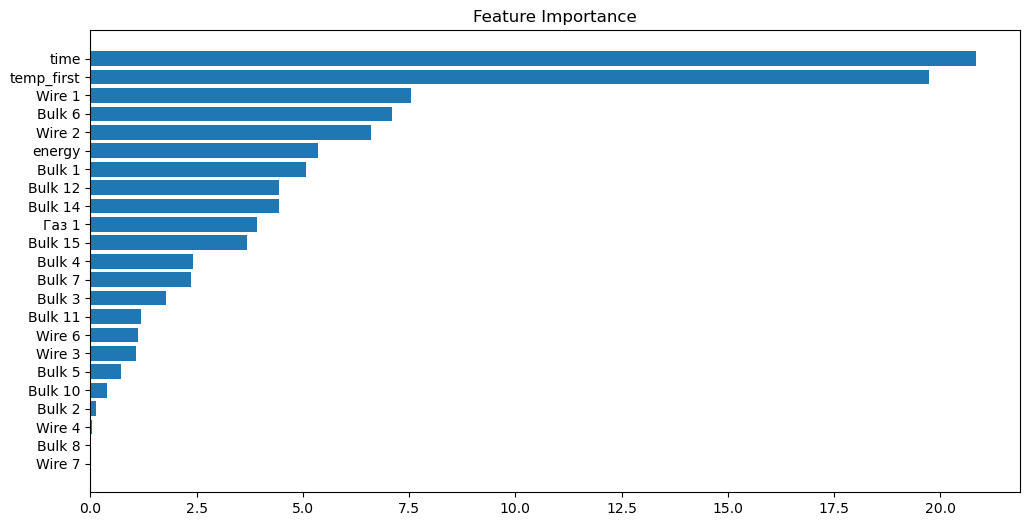

In [87]:
feature_importance = model_catboost.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(features_test.columns)[sorted_idx])
plt.title('Feature Importance')


Text(0.5, 1.0, 'SHAP Importance')

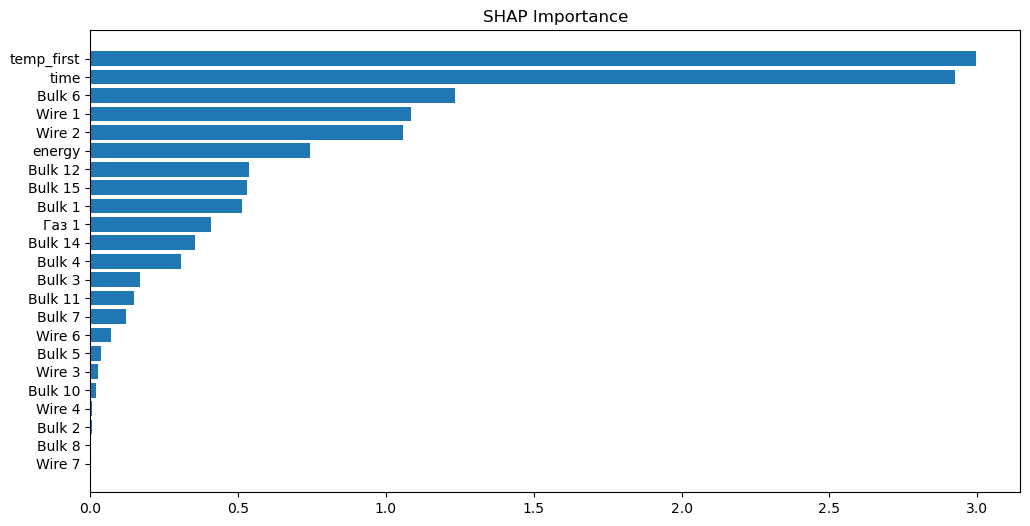

In [88]:

explainer = shap.Explainer(model_catboost)
shap_values = explainer(features_test)
shap_importance = shap_values.abs.mean(0).values
sorted_idx = shap_importance.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), shap_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(features_test.columns)[sorted_idx])
plt.title('SHAP Importance')


### Выводы

Рассмотрены четыри модели:
- модель среднего (Dummy model)
- линейная модель 
- линейная модель с L2 регулизацией
- модель случайного леса
- catboost

Все модели кроме модели среднего имеют метрику MAE<6.8 (средния при кросс валидации из 5 разбиений) на обучающей выборке. Наилучшие показатели у CatBoost. 

Выбранная модель CatBoost на тестовой выборке имеет MAE = 6.09

## Отчет

1. Следущие пункты плана были выполнены в полном объеме:
- Предобработка данных 
    - удаление аномалий
    - замена пропусков
    - объединение по номеру партии в один датасет
- Анализ данных. 
    - изучение корреляций
    - выбор признаков
    - выбор целевой метрики

Планировалось построить модели: Decision tree, Linear regression, CatBoost.
Но вместо Дерева решений было решено построить модель случайного леса. 
Дополнительно была рассмотрена модель среднего. 

Вместо выделения фисированной валидационной выборки использовали кросс-валидацию. 


2. При первичном анализе корреляций было замечено что конечная температура не коррелирует с признакими мощности, что очень подозрительно
и указывала на возможную ошибку в предобработке данных. Не смотря на отсутвии корреляции метрики удовлетворяли требуемым.
Проведя проверку кода и благодаря выданным иструкциям был сокращен список рассматриваемых партий. Таким образом, как сказано в инструкции, в объединённом датафрейме были оставлены  только те ключи (партии), которые есть во всех датафреймах.

3. Выделенны следущие шаги в задачи
   - изучение и анализ данных
   - чистка данных
   - построение признаков
   - объединение таблиц
   - маштабирование
   - построение, фитирование, определение метрик моделей используя кросс-валидацию
  
4. Рассмотрены четыри модели: модель среднего (Dummy model), линейная модель, линейная модель с L2 регулизацией, модель случайного леса, catboost. Все модели кроме модели среднего имеют метрику MAE<6.8 (средния при кросс валидации из 5 разбиений) на обучающей выборке.

Наилучшие показатели у CatBoost. Выбранная модель CatBoost на тестовой выборке имеет MAE = 6.09

Используемые признаки :'energy', 'time', 'temp_first', 'temp_last', 'Газ 1', 'Bulk 1', 'Bulk 10', 'Bulk 11', 'Bulk 12', 'Bulk 14', 'Bulk 15', 'Bulk 2',
       'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 'Wire 1','Wire 2', 'Wire 3', 'Wire 4', 'Wire 6', 'Wire 7'
   - признак time суммарное время нагрева - один из двух наиболее значимых
   - признак temp_first температура первого замера  - один из двух наиболее значимых
   - признак еnergy яв-ся оценкой потраченой энергии (произведение геометрического среднего мощностей и времени) за все периоды нагрева из зависит  мощностей и времени.
     признак оказался шестым по значимости.
   - признаки Bulk 6 Wire 1 Wire 2 оказались 3, 4, 5 в списке по важности

Гипер параметры модели
   - функция потерь loss_function = 'MAE',
   - число итераций iterations=300,
   - стартовое число случайно последовательности(seed)  random_state = 21023

Для улучшения предсказания модели предлагается:
   - рассмотреть физическую модель ковша для выделение наиболее значемых признаков.
   - детально изучить возможность сокращения числа признаков используя PCA.
   - проверить данные что бы замеры были до и после нагрева. на данный момент этой проверки нет. 
   - собрать дополнительные данные по тех процессу
   